<a href="https://colab.research.google.com/github/jedallas/xintongPaper/blob/master/Gnetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.6 MB/s eta 0:00:00


In [2]:
import torch
import torch_geometric
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear
import torch
import torch.nn.functional as F
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
relations=pd.read_excel(r"/content/drive/MyDrive/supplychain/data/Raw_Data/CA_ComSupplyChainAlliance.xlsx")
relations['统计截止日期'] = pd.to_datetime(relations['统计截止日期']).dt.year
relations.rename(columns={'统计截止日期': '年份', '证券代码': '股票代码'}, inplace=True)
#relations=relations[relations['年份']==2022]
relations=relations.loc[:,['股票代码','公司证券代码']]

In [5]:
node_features=pd.read_excel(r"/content/drive/MyDrive/supplychain/data/Raw_Data/node_features.xlsx")
node_features=node_features.drop(['报表类型编码','股票简称'],axis=1)
node_features['年份'] = pd.to_datetime(node_features['统计截止日期']).dt.year
node_features=node_features.drop('统计截止日期',axis=1)
#node_features=node_features[node_features['年份']==2022]
#node_features=node_features.drop('年份',axis=1)

In [ ]:
node_features

,股票代码,应收账款周转率A,应收账款周转率B,应收账款周转率C,应收账款周转率D,应收账款周转率TTM,存货周转率A,存货周转率B,存货周转率C,存货周转率D,...,固定资产周转率B,固定资产周转率C,固定资产周转率D,固定资产周转率TTM,总资产周转率A,总资产周转率B,总资产周转率C,总资产周转率D,总资产周转率TTM,年份
0,1,0.135220,0.229439,0.270441,0.270441,0.270441,NaN,NaN,NaN,NaN,...,9.842609,NaN,NaN,NaN,0.024688,0.028440,NaN,NaN,NaN,2011
1,1,0.351678,0.249591,0.249591,0.249591,0.249591,NaN,NaN,NaN,NaN,...,11.439127,11.439127,11.439127,11.439127,0.021716,0.026895,0.026895,0.026895,0.026895,2012
2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.998135,NaN,NaN,NaN,0.031973,0.033988,NaN,NaN,NaN,2020
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.220315,13.220315,13.220315,13.220315,0.030679,0.032157,0.032157,0.032157,0.032157,2021
4,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,13.687753,13.687753,13.687753,13.687753,0.029594,0.030745,0.030745,0.030745,0.030745,2022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62314,873703,2.793255,2.548368,2.548368,2.548368,2.548368,6.549481,6.531371,6.531371,6.531371,...,281.038967,281.038967,281.038967,281.038967,0.630324,0.697304,0.697304,0.697304,0.697304,2022
62315,873726,1.526908,1.655193,3.053817,3.053817,3.053817,1.400668,1.619388,2.801336,2.801336,...,4.410726,NaN,NaN,NaN,0.627885,0.749464,NaN,NaN,NaN,2022
62316,873806,2.456233,2.341408,4.912466,4.912466,4.912466,1.722579,1.518448,3.445158,3.445158,...,144.469364,NaN,NaN,NaN,0.634714,0.619954,NaN,NaN,NaN,2021
62317,873806,1.932124,2.237677,2.237677,2.237677,2.237677,1.591315,1.695660,1.695660,1.695660,...,62.105563,62.105563,62.105563,62.105563,0.587426,0.633263,0.633263,0.633263,0.633263,2022


In [6]:
merged_array = pd.concat([relations['股票代码'], relations['公司证券代码']])
keys = pd.Series(merged_array.unique())
node=pd.DataFrame(keys,columns=['股票代码'])
node.shape

(2314, 1)

In [7]:
node_features_result=node.merge(node_features,on=['股票代码'])

In [8]:
node_features_result['股票代码'].value_counts().keys()[node_features_result['股票代码'].value_counts().values==22]

Index([600570, 600438, 600477, 600027, 600022, 600021, 600491, 600584, 600546,
       600031, 600961, 600271, 600521, 600012, 600487, 600476, 600460, 600497,
       600449, 600446, 600429,   2008, 600409, 600039,   2011, 600459,   2034,
       600960, 600981, 600966, 600143, 600979, 600993, 600433,   2004, 600029,
         2023, 600114,   2024, 600004,   2037],
      dtype='int64', name='股票代码')

<Axes: >

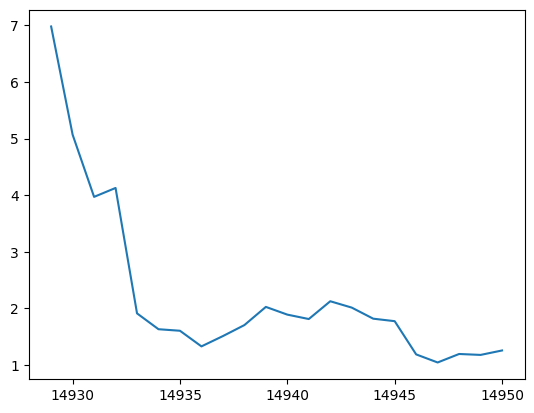

In [ ]:
case_=node_features_result.loc[node_features_result['股票代码']==600521]
case_['存货周转率B'].plot()

In [9]:
digital=pd.read_excel(r"/content/drive/MyDrive/supplychain/data/Raw_Data/digital_score.xlsx")
digital.rename(columns={'统计年度': '年份', '证券代码': '股票代码'}, inplace=True)
#digital=digital[digital['年份']==2022]


In [10]:
digital=digital.loc[:, ['股票代码','年份','战略引领评分','国民经济行业代码','国民经济行业名称']]

In [11]:
df=pd.merge(node_features_result, digital, on=['股票代码','年份'])
df['国民经济行业代码']=df['国民经济行业代码'].str.extract(r'(\d+)')

In [12]:
len(df['股票代码'].value_counts().keys())


1974

In [13]:
df['股票代码'].value_counts()

股票代码
4         12
601218    12
600967    12
600966    12
600963    12
          ..
839790     1
870299     1
870357     1
871753     1
838670     1
Name: count, Length: 1974, dtype: int64

In [14]:
# 初始化MinMaxScaler对象
scaler = MinMaxScaler()

# 拟合数据并进行转换
scaled_data = scaler.fit_transform(np.array(df['战略引领评分']).reshape(-1,1))

df['战略引领评分']=scaled_data

In [15]:
df['战略引领评分'].notnull().sum()

18551

In [ ]:
df


,股票代码,应收账款周转率A,应收账款周转率B,应收账款周转率C,应收账款周转率D,应收账款周转率TTM,存货周转率A,存货周转率B,存货周转率C,存货周转率D,...,固定资产周转率D,固定资产周转率TTM,总资产周转率A,总资产周转率B,总资产周转率C,总资产周转率D,总资产周转率TTM,年份,战略引领评分,国民经济行业代码
0,4,NaN,102.677725,102.677725,102.677725,102.677725,NaN,NaN,NaN,NaN,...,0.630754,0.630754,0.004889,0.004799,0.004799,0.004799,0.004799,2011,0.180453,27
1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.754885,0.754885,0.008055,0.006642,0.006642,0.006642,0.006642,2012,0.168035,27
2,4,2.953872,5.907743,5.907743,5.907743,5.907743,NaN,NaN,NaN,NaN,...,0.744977,0.744977,0.007108,0.007343,0.007343,0.007343,0.007343,2013,0.144063,27
3,4,2.182320,2.042607,2.042607,2.042607,2.042607,NaN,NaN,NaN,NaN,...,0.509311,0.509311,0.004462,0.004539,0.004539,0.004539,0.004539,2014,0.111259,27
4,4,4.139011,4.053671,4.053671,4.053671,4.053671,NaN,NaN,NaN,NaN,...,0.789455,0.789455,0.008589,0.008348,0.008348,0.008348,0.008348,2015,0.076216,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18546,603677,4.358299,4.654090,4.654090,4.654090,4.654090,3.963171,4.497929,4.497929,4.497929,...,3.846460,3.846460,0.974747,1.035978,1.035978,1.035978,1.035978,2021,0.258686,38
18547,603677,4.172222,4.025224,4.025224,4.025224,4.025224,4.062821,3.805690,3.805690,3.805690,...,3.347835,3.347835,0.889473,0.879432,0.879432,0.879432,0.879432,2022,0.415532,38
18548,601956,0.166554,0.328186,0.328186,0.328186,0.328186,377.670658,22.156121,22.156121,22.156121,...,0.634453,0.634453,0.004638,0.007362,0.007362,0.007362,0.007362,2020,0.286896,34
18549,601956,0.211315,0.262161,0.262161,0.262161,0.262161,33.807541,64.481494,64.481494,64.481494,...,1.418052,1.418052,0.012683,0.010937,0.010937,0.010937,0.010937,2021,0.253368,34


In [16]:
#print(merged_array)
arr = pd.Series(range(df['股票代码'].unique().shape[0]))
#print(arr)
# 假设keys和values是两个等长的数组
keys = df['股票代码'].unique()
values = arr
dictionary = dict(zip(keys, values))

In [17]:
len(dictionary)

1974

In [18]:
df=df.fillna(0)

In [19]:
relations_index=relations.replace(dictionary)

In [20]:
relations_index = relations_index.drop(relations_index[(relations_index['股票代码'] >= len(dictionary)) | (relations_index['公司证券代码'] >= len(dictionary))].index)


In [ ]:
relations_index

,股票代码,公司证券代码
0,0,898
1,0,1306
3,1,1307
4,1,1307
5,1,1307
...,...,...
5670,1305,1972
5671,1305,1200
5672,1305,1972
5673,1305,1973


In [21]:

torch.set_default_tensor_type(torch.FloatTensor)

x_=df.drop(['股票代码','战略引领评分','年份','国民经济行业代码','国民经济行业名称'],axis=1)

#x_['国民经济行业代码']=x_['国民经济行业代码'].astype(int)
y_=df['战略引领评分']
x=torch.tensor(x_.values,dtype=torch.float32)
y=torch.tensor(y_.values,dtype=torch.float32)

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


In [22]:
x.shape

torch.Size([18551, 41])

In [23]:
eighty_percentile = y.quantile(0.24)
y[y>=eighty_percentile]=1
y[y!=1]=0

In [24]:
start_list=relations_index['股票代码'].to_list()
end_list=relations_index['公司证券代码'].to_list()

In [25]:
edge_index=torch.tensor([start_list,end_list],dtype=torch.long)

In [26]:
from torch_geometric.data import Data
data = Data(x=x, edge_index=edge_index, y=y)

In [27]:
data

Data(x=[18551, 41], edge_index=[2, 5055], y=[18551])

In [ ]:
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(41,128)
        self.conv2= GCNConv(128,64)
        self.conv3= GCNConv(64,16)
        self.classifer = Linear(16,2)

    def forward(self, data):
        x = data.x
        x = self.conv1(x, edge_index)
        x = F.tanh(x)
        x = self.conv2(x, edge_index)
        x = F.tanh(x)
        x = self.conv3(x, edge_index)
        x = F.tanh(x)
        out = self.classifer(x)
        return out


model_gcn=GCN()
print(model_gcn)
GCN_loss_list=[]
GCN_acc_list=[]
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gcn.parameters(), lr=0.001, weight_decay=5e-4)

def train(data):
  optimizer.zero_grad()
  out = model_gcn(data)
  #print(out)
  data.y = data.y.long()
  loss = criterion(out, data.y)
  loss.backward()
  optimizer.step()

  predictions_gcn = torch.argmax(out, dim=1)
  correct= torch.sum(predictions_gcn == data.y)
  total= len(data.y)
  accuracy = correct / total
  return loss, accuracy, predictions_gcn

GCN(
  (conv1): GCNConv(41, 128)
  (conv2): GCNConv(128, 64)
  (conv3): GCNConv(64, 16)
  (classifer): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
for epoch in range(10000):
  loss,accuracy,predictions_gcn = train(data)
  if epoch%100 == 0:
    print(loss,accuracy)
    GCN_loss_list.append(loss.item())
    GCN_acc_list.append(accuracy.item())
print(classification_report(y,predictions_gcn,target_names = ['0','1']))

tensor(0.7051, grad_fn=<NllLossBackward0>) tensor(0.5326)
tensor(0.5237, grad_fn=<NllLossBackward0>) tensor(0.7610)
tensor(0.5025, grad_fn=<NllLossBackward0>) tensor(0.7690)
tensor(0.4763, grad_fn=<NllLossBackward0>) tensor(0.7845)
tensor(0.4562, grad_fn=<NllLossBackward0>) tensor(0.7946)
tensor(0.4454, grad_fn=<NllLossBackward0>) tensor(0.8020)
tensor(0.4351, grad_fn=<NllLossBackward0>) tensor(0.8057)
tensor(0.4244, grad_fn=<NllLossBackward0>) tensor(0.8128)
tensor(0.4166, grad_fn=<NllLossBackward0>) tensor(0.8168)
tensor(0.4119, grad_fn=<NllLossBackward0>) tensor(0.8160)
tensor(0.4021, grad_fn=<NllLossBackward0>) tensor(0.8262)
tensor(0.3932, grad_fn=<NllLossBackward0>) tensor(0.8307)
tensor(0.3878, grad_fn=<NllLossBackward0>) tensor(0.8323)
tensor(0.3824, grad_fn=<NllLossBackward0>) tensor(0.8354)
tensor(0.3766, grad_fn=<NllLossBackward0>) tensor(0.8372)
tensor(0.3709, grad_fn=<NllLossBackward0>) tensor(0.8396)
tensor(0.3682, grad_fn=<NllLossBackward0>) tensor(0.8407)
tensor(0.3621,

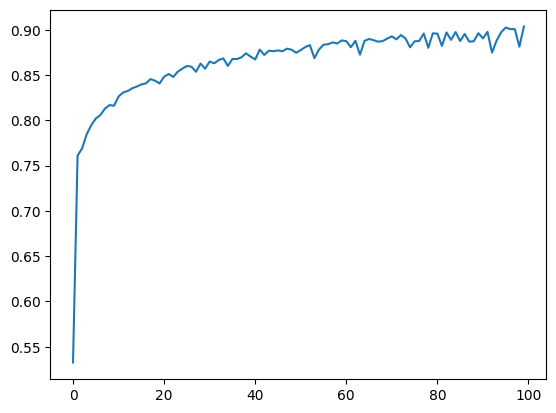

In [ ]:

plt.plot(GCN_acc_list)

with open('/content/drive/MyDrive/supplychain/GCN.pkl', 'wb') as file:
    pickle.dump((GCN_loss_list, GCN_acc_list), file)

In [ ]:
import pandas as pd
import statsmodels.api as sm


# 利用statsmodels进行线性回归
model = sm.OLS(np.array(y), np.array(x)).fit()

# 打印模型的回归结果
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.347
Model:                            OLS   Adj. R-squared (uncentered):              0.346
Method:                 Least Squares   F-statistic:                              491.9
Date:                Fri, 07 Jun 2024   Prob (F-statistic):                        0.00
Time:                        02:15:58   Log-Likelihood:                         -19839.
No. Observations:               18551   AIC:                                  3.972e+04
Df Residuals:                   18531   BIC:                                  3.988e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
#sgdc = SGDClassifier()

lr.fit(np.array(x),np.array(y))
# 用predict对X_test进行预测
lr_y_predict = lr.predict(np.array(x))
# 从sklearn.metrics导入accuracy_score，用来做分类准确率的评估。
from sklearn.metrics import accuracy_score

print('%s: %f'%('使用逻辑斯蒂回归模型做分类的准确率为', accuracy_score(np.array(y), lr_y_predict)))
#print('Accuaracy of LR Classifier:',lr.score(X_test, y_test))
print(classification_report(np.array(y),lr_y_predict,target_names = ['0','1']))

使用逻辑斯蒂回归模型做分类的准确率为: 0.760444
              precision    recall  f1-score   support

           0       0.27      0.00      0.00      4434
           1       0.76      1.00      0.86     14117

    accuracy                           0.76     18551
   macro avg       0.52      0.50      0.43     18551
weighted avg       0.64      0.76      0.66     18551



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
class MLPClassifier(nn.Module):
    def __init__(self):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(41, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 16)
        self.classifer = Linear(16,2)

    def forward(self, data):
        x = data.x
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        out = self.classifer(x)
        return out


model_mlp=MLPClassifier()
print(model_mlp)
MLP_loss_list=[]
MLP_acc_list=[]
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=0.0001, weight_decay=5e-4)

def train(data):
  optimizer.zero_grad()
  out = model_mlp(data)
  #print(out)
  data.y = data.y.long()
  loss = criterion(out, data.y)
  loss.backward()
  optimizer.step()

  predictions_mlp = torch.argmax(out, dim=1)
  #print(predictions_mlp)
  correct= torch.sum(predictions_mlp == data.y)
  total= len(data.y)
  accuracy = correct / total
  return loss, accuracy, predictions_mlp

MLPClassifier(
  (fc1): Linear(in_features=41, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=16, bias=True)
  (classifer): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
for epoch in range(10000):
  loss,accuracy,predictions_mlp = train(data)
  if epoch%100 == 0:
    print(loss,accuracy)
    MLP_loss_list.append(loss.item())
    MLP_acc_list.append(accuracy.item())
print(classification_report(y,predictions_mlp,target_names = ['0','1']))

tensor(0.6483, grad_fn=<NllLossBackward0>) tensor(0.7486)
tensor(0.5450, grad_fn=<NllLossBackward0>) tensor(0.7608)
tensor(0.5373, grad_fn=<NllLossBackward0>) tensor(0.7608)
tensor(0.5310, grad_fn=<NllLossBackward0>) tensor(0.7608)
tensor(0.5251, grad_fn=<NllLossBackward0>) tensor(0.7611)
tensor(0.5197, grad_fn=<NllLossBackward0>) tensor(0.7621)
tensor(0.5148, grad_fn=<NllLossBackward0>) tensor(0.7637)
tensor(0.5105, grad_fn=<NllLossBackward0>) tensor(0.7664)
tensor(0.5064, grad_fn=<NllLossBackward0>) tensor(0.7686)
tensor(0.5021, grad_fn=<NllLossBackward0>) tensor(0.7713)
tensor(0.4976, grad_fn=<NllLossBackward0>) tensor(0.7752)
tensor(0.4924, grad_fn=<NllLossBackward0>) tensor(0.7782)
tensor(0.4880, grad_fn=<NllLossBackward0>) tensor(0.7807)
tensor(0.4841, grad_fn=<NllLossBackward0>) tensor(0.7825)
tensor(0.4801, grad_fn=<NllLossBackward0>) tensor(0.7857)
tensor(0.4757, grad_fn=<NllLossBackward0>) tensor(0.7878)
tensor(0.4710, grad_fn=<NllLossBackward0>) tensor(0.7901)
tensor(0.4663,

In [ ]:
with open('/content/drive/MyDrive/supplychain/MLP.pkl', 'wb') as file:
    pickle.dump((MLP_loss_list, MLP_acc_list), file)

In [30]:
from torch_geometric.nn import SAGEConv
class SAGE(torch.nn.Module):
    def __init__(self):
        super(SAGE,self).__init__()
        self.conv1 = SAGEConv(41,128)
        self.conv2= SAGEConv(128,64)
        self.conv3= SAGEConv(64,16)
        self.classifer = Linear(16,2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.tanh(x)
        x = self.conv2(x, edge_index)
        x = F.tanh(x)
        x = self.conv3(x, edge_index)
        x = F.tanh(x)
        out = self.classifer(x)

        return out

model_sage=SAGE()
print(model_sage)
SAGE_loss_list=[]
SAGE_acc_list=[]
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_sage.parameters(), lr=0.001, weight_decay=5e-4)

def train(data):
  optimizer.zero_grad()
  out = model_sage(data)
  #print(out)
  data.y = data.y.long()
  loss = criterion(out, data.y) # semi-supervised
  loss.backward()
  optimizer.step()

  predictions_sage = torch.argmax(out, dim=1)
  correct= torch.sum(predictions_sage == data.y)
  total= len(data.y)
  accuracy = correct / total
  return loss, accuracy, predictions_sage

SAGE(
  (conv1): SAGEConv(41, 128, aggr=mean)
  (conv2): SAGEConv(128, 64, aggr=mean)
  (conv3): SAGEConv(64, 16, aggr=mean)
  (classifer): Linear(in_features=16, out_features=2, bias=True)
)


In [51]:
for epoch in range(10000):
  loss,accuracy,predictions_sage = train(data)
  if epoch%100 == 0:
    print(loss,accuracy)
    SAGE_loss_list.append(loss.item())
    SAGE_acc_list.append(accuracy.item())
  if accuracy.item()>0.95:
    break
print(classification_report(y,predictions_sage,target_names = ['0','1']))

tensor(0.1536, grad_fn=<NllLossBackward0>) tensor(0.9377)
tensor(0.1544, grad_fn=<NllLossBackward0>) tensor(0.9376)
tensor(0.1522, grad_fn=<NllLossBackward0>) tensor(0.9395)
tensor(0.1703, grad_fn=<NllLossBackward0>) tensor(0.9301)
tensor(0.1696, grad_fn=<NllLossBackward0>) tensor(0.9346)
tensor(0.1731, grad_fn=<NllLossBackward0>) tensor(0.9332)
tensor(0.1600, grad_fn=<NllLossBackward0>) tensor(0.9360)
tensor(0.1553, grad_fn=<NllLossBackward0>) tensor(0.9384)
tensor(0.1537, grad_fn=<NllLossBackward0>) tensor(0.9388)
tensor(0.1518, grad_fn=<NllLossBackward0>) tensor(0.9393)
tensor(0.1511, grad_fn=<NllLossBackward0>) tensor(0.9395)
tensor(0.1512, grad_fn=<NllLossBackward0>) tensor(0.9404)
tensor(0.1504, grad_fn=<NllLossBackward0>) tensor(0.9402)
tensor(0.1523, grad_fn=<NllLossBackward0>) tensor(0.9397)
tensor(0.1596, grad_fn=<NllLossBackward0>) tensor(0.9345)
tensor(0.1537, grad_fn=<NllLossBackward0>) tensor(0.9372)
tensor(0.1614, grad_fn=<NllLossBackward0>) tensor(0.9345)
tensor(0.1515,

In [59]:
import torch

#torch.save(model_sage.state_dict(), 'model_sage.pth')

# 如果你想保存整个模型
torch.save(model_sage, '/content/drive/MyDrive/supplychain/model/model_sage.pth')

In [60]:
df.to_excel('/content/drive/MyDrive/supplychain/data/df.xlsx', index=False)

In [56]:
predictions_sage.shape
with open('/content/drive/MyDrive/supplychain/SAGE_BEST.pkl', 'wb') as file:
    pickle.dump((SAGE_loss_list, SAGE_acc_list, predictions_sage), file)

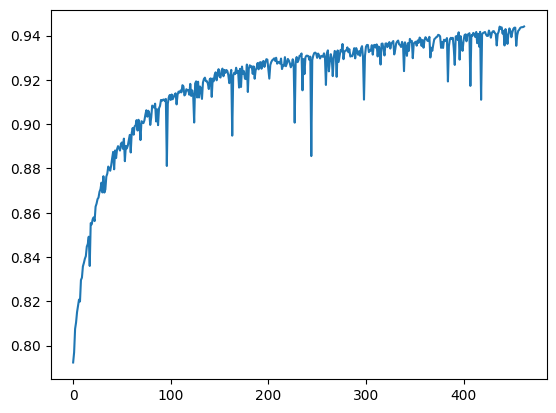

In [55]:
plt.plot(SAGE_acc_list[2:])

In [ ]:
for epoch in range(10000):
  loss,accuracy,predictions_sage = train(data)
  if epoch%100 == 0:
    print(loss,accuracy)
    SAGE_loss_list.append(loss.item())
    SAGE_acc_list.append(accuracy.item())
print(classification_report(y,predictions_sage,target_names = ['0','1']))

tensor(0.6624, grad_fn=<NllLossBackward0>) tensor(0.7190)
tensor(0.5129, grad_fn=<NllLossBackward0>) tensor(0.7701)
tensor(0.4710, grad_fn=<NllLossBackward0>) tensor(0.7917)
tensor(0.4494, grad_fn=<NllLossBackward0>) tensor(0.8014)
tensor(0.4311, grad_fn=<NllLossBackward0>) tensor(0.8080)
tensor(0.4180, grad_fn=<NllLossBackward0>) tensor(0.8145)
tensor(0.4113, grad_fn=<NllLossBackward0>) tensor(0.8169)
tensor(0.4067, grad_fn=<NllLossBackward0>) tensor(0.8210)
tensor(0.3962, grad_fn=<NllLossBackward0>) tensor(0.8257)
tensor(0.3878, grad_fn=<NllLossBackward0>) tensor(0.8304)
tensor(0.3827, grad_fn=<NllLossBackward0>) tensor(0.8324)
tensor(0.3768, grad_fn=<NllLossBackward0>) tensor(0.8365)
tensor(0.3860, grad_fn=<NllLossBackward0>) tensor(0.8320)
tensor(0.3690, grad_fn=<NllLossBackward0>) tensor(0.8378)
tensor(0.3625, grad_fn=<NllLossBackward0>) tensor(0.8419)
tensor(0.3560, grad_fn=<NllLossBackward0>) tensor(0.8463)
tensor(0.3594, grad_fn=<NllLossBackward0>) tensor(0.8432)
tensor(0.3528,

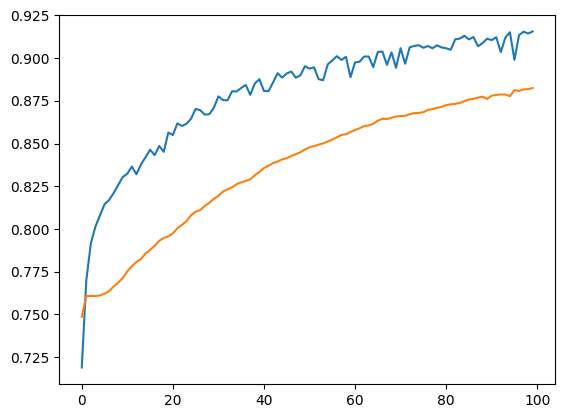

In [ ]:
plt.plot(SAGE_acc_list)
plt.plot(MLP_acc_list)


with open('/content/drive/MyDrive/supplychain/SAGE.pkl', 'wb') as file:
    pickle.dump((SAGE_loss_list, SAGE_acc_list), file)

In [ ]:
from torch_geometric.nn import GATConv
class GAN(torch.nn.Module):
    def __init__(self):
        super(GAN,self).__init__()
        self.conv1 = GATConv(41,128)
        self.conv2= GATConv(128,64)
        self.conv3= GATConv(64,16)
        self.classifer = Linear(16,2)

    def forward(self, data):
        x = data.x
        x = self.conv1(x, edge_index)
        x = F.tanh(x)
        x = self.conv2(x, edge_index)
        x = F.tanh(x)
        x = self.conv3(x, edge_index)
        x = F.tanh(x)
        out = self.classifer(x)
        return out

model_gan=GAN()
print(model_gan)
GAN_loss_list=[]
GAN_acc_list=[]
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gan.parameters(), lr=0.001, weight_decay=5e-4)

def train(data):
  optimizer.zero_grad()
  out = model_gan(data)
  #print(out)
  data.y = data.y.long()
  loss = criterion(out, data.y) # semi-supervised
  loss.backward()
  optimizer.step()

  predictions_gan = torch.argmax(out, dim=1)
  correct= torch.sum(predictions_gan == data.y)
  total= len(data.y)
  accuracy = correct / total
  return loss, accuracy,predictions_gan


GAN(
  (conv1): GATConv(41, 128, heads=1)
  (conv2): GATConv(128, 64, heads=1)
  (conv3): GATConv(64, 16, heads=1)
  (classifer): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
for epoch in range(10000):
  loss,accuracy,predictions_gan = train(data)
  if epoch%100 == 0:
    print(loss,accuracy)
    GAN_loss_list.append(loss.item())
    GAN_acc_list.append(accuracy.item())
print(classification_report(y,predictions_gan,target_names = ['0','1']))

tensor(0.8469, grad_fn=<NllLossBackward0>) tensor(0.2590)
tensor(0.5370, grad_fn=<NllLossBackward0>) tensor(0.7607)
tensor(0.5184, grad_fn=<NllLossBackward0>) tensor(0.7619)
tensor(0.4984, grad_fn=<NllLossBackward0>) tensor(0.7734)
tensor(0.4807, grad_fn=<NllLossBackward0>) tensor(0.7856)
tensor(0.4642, grad_fn=<NllLossBackward0>) tensor(0.7944)
tensor(0.4525, grad_fn=<NllLossBackward0>) tensor(0.8018)
tensor(0.4410, grad_fn=<NllLossBackward0>) tensor(0.8052)
tensor(0.4325, grad_fn=<NllLossBackward0>) tensor(0.8117)
tensor(0.4233, grad_fn=<NllLossBackward0>) tensor(0.8174)
tensor(0.4149, grad_fn=<NllLossBackward0>) tensor(0.8207)
tensor(0.4133, grad_fn=<NllLossBackward0>) tensor(0.8206)
tensor(0.4075, grad_fn=<NllLossBackward0>) tensor(0.8228)
tensor(0.3978, grad_fn=<NllLossBackward0>) tensor(0.8278)
tensor(0.3959, grad_fn=<NllLossBackward0>) tensor(0.8298)
tensor(0.3875, grad_fn=<NllLossBackward0>) tensor(0.8317)
tensor(0.3815, grad_fn=<NllLossBackward0>) tensor(0.8353)
tensor(0.3753,

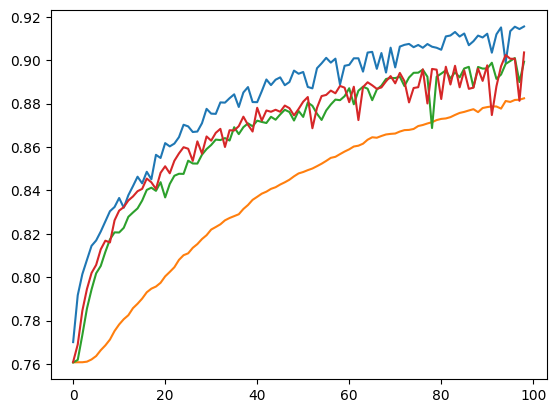

In [ ]:
plt.plot(SAGE_acc_list[1:],label='SAGEGraph')
plt.plot(MLP_acc_list[1:],label='MLP')
plt.plot(GAN_acc_list[1:],label='GAT')
plt.plot(GCN_acc_list[1:],label='GCN')
with open('/content/drive/MyDrive/supplychain/GAN.pkl', 'wb') as file:
    pickle.dump((GAN_loss_list, GAN_acc_list), file)

In [ ]:

from torch_geometric.nn import TransformerConv
class TransformerGNN(torch.nn.Module):
    def __init__(self):
        super(TransformerGNN,self).__init__()
        self.conv1 = TransformerConv(41,128)
        self.conv2= TransformerConv(128,64)
        self.conv3= TransformerConv(64,16)
        self.classifer = Linear(16,2)

    def forward(self, data):
        x = data.x
        x = self.conv1(x, edge_index)
        x = F.tanh(x)
        x = self.conv2(x, edge_index)
        x = F.tanh(x)
        x = self.conv3(x, edge_index)
        x = F.tanh(x)
        out = self.classifer(x)

        return out

model_trans=TransformerGNN()
print(model_trans)
TransformerGNN_loss_list=[]
TransformerGNN_acc_list=[]
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_trans.parameters(), lr=0.001, weight_decay=5e-4)

def train(data):
  optimizer.zero_grad()
  out = model_trans(data)
  #print(out)
  data.y = data.y.long()
  loss = criterion(out, data.y) # semi-supervised
  loss.backward()
  optimizer.step()

  predictions_trans = torch.argmax(out, dim=1)
  correct= torch.sum(predictions_trans == data.y)
  total= len(data.y)
  accuracy = correct / total
  return loss, accuracy, predictions_trans


TransformerGNN(
  (conv1): TransformerConv(41, 128, heads=1)
  (conv2): TransformerConv(128, 64, heads=1)
  (conv3): TransformerConv(64, 16, heads=1)
  (classifer): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
for epoch in range(10000):
  loss,accuracy,predictions_trans = train(data)
  if epoch%100 == 0:
    print(loss,accuracy)
    TransformerGNN_loss_list.append(loss.item())
    TransformerGNN_acc_list.append(accuracy.item())
print(classification_report(y,predictions_trans,target_names = ['0','1']))

tensor(0.7198, grad_fn=<NllLossBackward0>) tensor(0.3826)
tensor(0.5142, grad_fn=<NllLossBackward0>) tensor(0.7703)
tensor(0.4709, grad_fn=<NllLossBackward0>) tensor(0.7928)
tensor(0.4464, grad_fn=<NllLossBackward0>) tensor(0.8043)
tensor(0.4321, grad_fn=<NllLossBackward0>) tensor(0.8106)
tensor(0.4204, grad_fn=<NllLossBackward0>) tensor(0.8156)
tensor(0.4124, grad_fn=<NllLossBackward0>) tensor(0.8195)
tensor(0.4058, grad_fn=<NllLossBackward0>) tensor(0.8223)
tensor(0.3983, grad_fn=<NllLossBackward0>) tensor(0.8254)
tensor(0.3937, grad_fn=<NllLossBackward0>) tensor(0.8289)
tensor(0.3907, grad_fn=<NllLossBackward0>) tensor(0.8279)
tensor(0.3816, grad_fn=<NllLossBackward0>) tensor(0.8327)
tensor(0.3719, grad_fn=<NllLossBackward0>) tensor(0.8398)
tensor(0.3681, grad_fn=<NllLossBackward0>) tensor(0.8416)
tensor(0.3642, grad_fn=<NllLossBackward0>) tensor(0.8442)
tensor(0.3565, grad_fn=<NllLossBackward0>) tensor(0.8460)
tensor(0.4081, grad_fn=<NllLossBackward0>) tensor(0.8245)
tensor(0.3462,

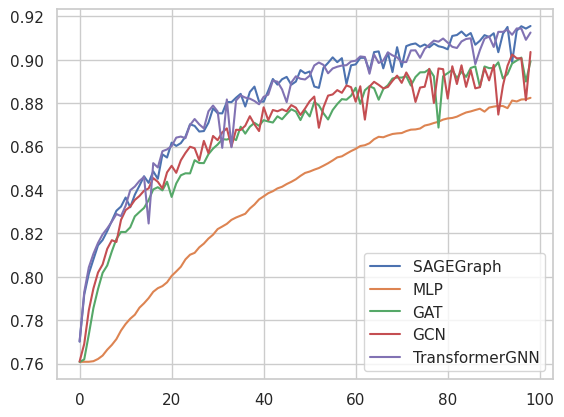

In [ ]:
plt.plot(SAGE_acc_list[1:],label='SAGEGraph')
plt.plot(MLP_acc_list[1:],label='MLP')
plt.plot(GAN_acc_list[1:],label='GAT')
plt.plot(GCN_acc_list[1:],label='GCN')
plt.plot(TransformerGNN_acc_list[1:],label='TransformerGNN')
plt.legend()
with open('/content/drive/MyDrive/supplychain/TransformerGNN.pkl', 'wb') as file:
    pickle.dump((TransformerGNN_loss_list, TransformerGNN_acc_list), file)

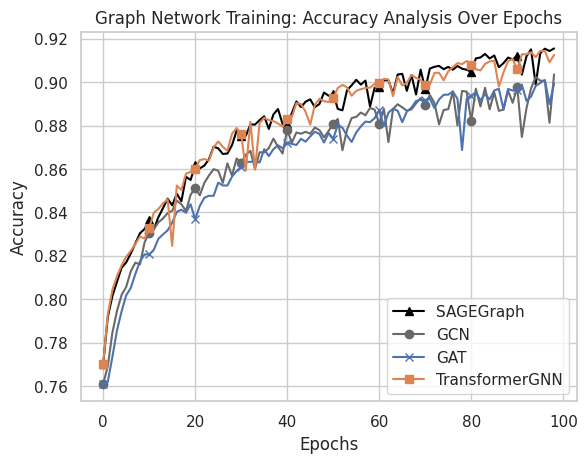

In [ ]:
#ensemble


import seaborn as sns
import matplotlib.pyplot as plt

# 使用Seaborn设置样式
sns.set(style="whitegrid")

#x =  list(range(1, 10001))
indices_to_mark = list(np.arange(0, len(SAGE_acc_list), 10))


plt.plot(SAGE_acc_list[1:],label='SAGEGraph',color='black',marker='^',markersize=6, markevery=indices_to_mark)
plt.plot(GCN_acc_list[1:],label='GCN',color='#696969',marker='o',markersize=6, markevery=indices_to_mark)
plt.plot(GAN_acc_list[1:],label='GAT',marker='x',markersize=6, markevery=indices_to_mark)
plt.plot(TransformerGNN_acc_list[1:],label='TransformerGNN',marker='s',markersize=6, markevery=indices_to_mark)
plt.title('Graph Network Training: Accuracy Analysis Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [ ]:
ensemble_acc_list=[]
ensemble_loss_list=[]
for epoch in range(10000):
  loss,accuracy,predictions_en = train(data)
  if epoch%100 == 0:
    print(loss,accuracy)
    ensemble_acc_list.append(loss.item())
    ensemble_loss_list.append(accuracy.item())
print(classification_report(y,predictions_en,target_names = ['0','1']))

tensor(0.2169, grad_fn=<NllLossBackward0>) tensor(0.9096)
tensor(0.2254, grad_fn=<NllLossBackward0>) tensor(0.9067)
tensor(0.2114, grad_fn=<NllLossBackward0>) tensor(0.9154)
tensor(0.2136, grad_fn=<NllLossBackward0>) tensor(0.9143)
tensor(0.2090, grad_fn=<NllLossBackward0>) tensor(0.9147)
tensor(0.2088, grad_fn=<NllLossBackward0>) tensor(0.9142)
tensor(0.2056, grad_fn=<NllLossBackward0>) tensor(0.9171)
tensor(0.2068, grad_fn=<NllLossBackward0>) tensor(0.9167)
tensor(0.3258, grad_fn=<NllLossBackward0>) tensor(0.8531)
tensor(0.2166, grad_fn=<NllLossBackward0>) tensor(0.9151)
tensor(0.2111, grad_fn=<NllLossBackward0>) tensor(0.9166)
tensor(0.2094, grad_fn=<NllLossBackward0>) tensor(0.9173)
tensor(0.2071, grad_fn=<NllLossBackward0>) tensor(0.9176)
tensor(0.2053, grad_fn=<NllLossBackward0>) tensor(0.9180)
tensor(0.2040, grad_fn=<NllLossBackward0>) tensor(0.9184)
tensor(0.2038, grad_fn=<NllLossBackward0>) tensor(0.9189)
tensor(0.2026, grad_fn=<NllLossBackward0>) tensor(0.9195)
tensor(0.2054,